In [21]:
# %%
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import json

In [22]:
# %%
data_path = Path("../data/processed/istdata_clean.parquet")

lf = (
    pl.scan_parquet(data_path)
    .select([
        "BPUIC",
        "HALTESTELLEN_NAME",
        "LINIEN_TEXT",
        "BETREIBER_NAME",
        "delay_arrival_s",
        "ANKUNFTSZEIT"
    ])
)

print("LazyFrame aufgebaut (noch kein RAM Verbrauch):")
lf

LazyFrame aufgebaut (noch kein RAM Verbrauch):


In [23]:
# %%
lf_feat = (
    lf
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
        pl.col("ANKUNFTSZEIT").dt.hour().alias("hour"),
        pl.col("ANKUNFTSZEIT").dt.weekday().alias("weekday_num")
    ])
    .with_columns([
        pl.when(pl.col("hour").is_between(7, 9) | pl.col("hour").is_between(16, 19))
          .then(pl.lit("peak"))
          .otherwise(pl.lit("offpeak"))
          .alias("time_category")
    ])
)

print("Feature-LF bereit.")
lf_feat

Feature-LF bereit.


In [24]:
# %%
# STRATEGIE: Nur Züge filtern VOR der Aggregation um Speicher zu sparen
lf_station = (
    lf_feat
    .filter(pl.col("LINIEN_TEXT").str.contains("IC|IR|RE|S"))  # Nur relevante Züge
    .group_by(["BPUIC", "HALTESTELLEN_NAME"])
    .agg([
        pl.len().alias("n_obs"),
        pl.col("delay_min").mean().alias("mean_delay"),
        pl.col("delay_min").median().alias("median_delay"),
        pl.col("delay_min").var().alias("var_delay"),
        pl.col("delay_min").filter(pl.col("time_category") == "peak").mean().alias("mean_peak"),
        pl.col("delay_min").filter(pl.col("time_category") == "offpeak").mean().alias("mean_offpeak"),
        pl.col("hour").mean().alias("mean_hour"),  # Für Tageszeit-Profil
    ])
    .filter(pl.col("n_obs") >= 100)  # Nur Stationen mit genug Daten
)

print("Starte Aggregation... (kann 1-2 Min dauern)")
station_df = lf_station.collect()
print(f"✓ Fertig! {station_df.shape[0]} Stationen geladen")
station_df.head(10)

Starte Aggregation... (kann 1-2 Min dauern)
✓ Fertig! 1133 Stationen geladen
✓ Fertig! 1133 Stationen geladen


BPUIC,HALTESTELLEN_NAME,n_obs,mean_delay,median_delay,var_delay,mean_peak,mean_offpeak,mean_hour
str,str,u32,f64,f64,f64,f64,f64,f64
"""8500032""","""Sommerau""",822,1.185381,0.85,2.654,1.276834,1.127679,12.990268
"""8503209""","""Pfäffikon SZ""",11950,0.66784,0.583333,1.615012,0.769159,0.621107,13.43039
"""8503095""","""Sood-Oberleimbach""",4318,1.129528,1.108333,0.57939,1.268298,1.016211,13.400648
"""8503124""","""Aathal""",2426,1.223818,0.933333,1.12294,1.448234,1.10496,13.187964
"""8506368""","""Gfeld""",3050,-3.928585,0.683333,7461.406824,1.395946,-7.666453,13.137377
"""8509366""","""Brusio""",298,2.848266,1.658333,16.190694,2.809583,2.874345,13.493289
"""8506125""","""Altnau""",2449,0.386226,0.116667,1.540393,0.579667,0.285054,13.113924
"""8503299""","""Hurden""",2143,1.091453,0.8,2.170535,1.246567,0.991456,13.014466
"""8500136""","""Basel Dreispitz""",4375,0.525958,0.3,0.819946,0.537924,0.518977,13.286171


## Hypothese: Spatiale Clustering von Schweizer Bahnhöfen

**H₁:** Grosse Schweizer Bahnhöfe clusterisieren sich in spatialen Delay-Mustern:
- Bahnhöfe in urbanen Regionen haben signifikant andere Delay-Profile als ländliche Bahnhöfe
- Selbst bei Kontrolle von Tageszeit (Peak vs. Off-Peak)

**Methodik:**
1. Aggregation von Delay-Metriken pro Station
2. Integration mit Geo-Koordinaten
3. K-Means Clustering basierend auf Delay-Profilen
4. Visualisierung auf Schweiz-Karte
5. Statistischer Test (Permutation Test)

In [25]:
# %%
# Geo-Koordinaten laden
stops_path = Path("../data/external/dienststellen.csv")
stops = pl.read_csv(stops_path, separator=";")

# BPUIC und Koordinaten extrahieren
stops_clean = stops.with_columns([
    pl.col("operatingPointKilometerMasterNumber").cast(pl.Utf8).alias("BPUIC"),
    pl.col("Geoposition").str.split(",").list.get(0).str.strip_chars().cast(pl.Float64).alias("lat"),
    pl.col("Geoposition").str.split(",").list.get(1).str.strip_chars().cast(pl.Float64).alias("lon")
]).select(["BPUIC", "lat", "lon"]).drop_nulls()

# Mit Delay-Daten joinen
station_geo = station_df.join(stops_clean, on="BPUIC", how="inner")

print(f"✓ {station_geo.shape[0]} Stationen mit Geo-Koordinaten")
station_geo.head()

✓ 1341 Stationen mit Geo-Koordinaten


BPUIC,HALTESTELLEN_NAME,n_obs,mean_delay,median_delay,var_delay,mean_peak,mean_offpeak,mean_hour,lat,lon
str,str,u32,f64,f64,f64,f64,f64,f64,f64,f64
"""8500121""","""Courfaivre""",2158,1.414767,1.066667,2.253119,1.607179,1.301191,12.87025,47.335083,7.291166
"""8500122""","""Bassecourt""",2158,0.926715,0.533333,2.750606,1.117817,0.821127,13.006951,47.336687,7.246846
"""8500126""","""Porrentruy""",2181,0.372497,0.25,1.783203,0.135215,0.454077,13.043705,47.420916,7.080077
"""8500109""","""Delémont""",3407,0.889116,0.55,2.756401,1.079136,0.782708,13.528373,47.362013,7.350063
"""8500136""","""Basel Dreispitz""",4375,0.525958,0.3,0.819946,0.537924,0.518977,13.286171,47.537436,7.609596


In [16]:
# %%
# Features für Clustering vorbereiten
# Wir nutzen: mean_delay, var_delay, mean_peak, mean_offpeak
from sklearn.preprocessing import StandardScaler

# Zu Pandas für sklearn
station_pd = station_geo.to_pandas()

# Features auswählen (NaN entfernen)
features = ["mean_delay", "var_delay", "mean_peak", "mean_offpeak"]
X = station_pd[features].fillna(0).values

# Standardisieren (wichtig für K-Means!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature-Matrix: {X_scaled.shape}")
print(f"Features: {features}")

Feature-Matrix: (1341, 4)
Features: ['mean_delay', 'var_delay', 'mean_peak', 'mean_offpeak']


In [26]:
# %%
# K-Means Clustering mit k=3 (Urban / Suburban / Rural)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

station_pd["cluster"] = clusters

# Cluster-Statistiken
print("Cluster-Verteilung:")
print(station_pd["cluster"].value_counts().sort_index())

print("\nCluster-Charakteristiken:")
cluster_stats = []
for i in range(3):
    cluster_data = station_pd[station_pd["cluster"] == i]
    stats = {
        'cluster': i,
        'mean_delay': cluster_data['mean_delay'].mean(),
        'mean_peak': cluster_data['mean_peak'].mean(),
        'mean_offpeak': cluster_data['mean_offpeak'].mean(),
        'var_delay': cluster_data['var_delay'].mean()
    }
    cluster_stats.append(stats)
    print(f"\n📍 Cluster {i} ({len(cluster_data)} Stationen):")
    print(f"  Ø Delay: {stats['mean_delay']:.2f} min")
    print(f"  Ø Peak:  {stats['mean_peak']:.2f} min")
    print(f"  Ø Off-Peak: {stats['mean_offpeak']:.2f} min")
    print(f"  Ø Varianz: {stats['var_delay']:.2f} min²")
    print(f"  Top Stationen: {', '.join(cluster_data.nlargest(3, 'n_obs')['HALTESTELLEN_NAME'].values)}")

# Cluster automatisch basierend auf mean_delay umbenennen
cluster_mapping = sorted([(stats['mean_delay'], i) for i, stats in enumerate(cluster_stats)])
print("\n🔄 Cluster-Reihenfolge nach Durchschnittsverspätung:")
for rank, (delay, cluster_id) in enumerate(cluster_mapping):
    print(f"  Rang {rank}: Cluster {cluster_id} = {delay:.2f} min")

Cluster-Verteilung:
cluster
0    850
1     10
2    481
Name: count, dtype: int64

Cluster-Charakteristiken:

📍 Cluster 0 (850 Stationen):
  Ø Delay: 0.61 min
  Ø Peak:  0.67 min
  Ø Off-Peak: 0.57 min
  Ø Varianz: 73.70 min²
  Top Stationen: Zürich HB, Zürich HB, Zürich HB

📍 Cluster 1 (10 Stationen):
  Ø Delay: -6.52 min
  Ø Peak:  1.81 min
  Ø Off-Peak: -11.77 min
  Ø Varianz: 11629.49 min²
  Top Stationen: Bendlehn, Gfeld, Rosental

📍 Cluster 2 (481 Stationen):
  Ø Delay: 1.51 min
  Ø Peak:  1.67 min
  Ø Off-Peak: 1.41 min
  Ø Varianz: 18.15 min²
  Top Stationen: Zürich Oerlikon, Zürich Oerlikon, Zürich Oerlikon

🔄 Cluster-Reihenfolge nach Durchschnittsverspätung:
  Rang 0: Cluster 1 = -6.52 min
  Rang 1: Cluster 0 = 0.61 min
  Rang 2: Cluster 2 = 1.51 min


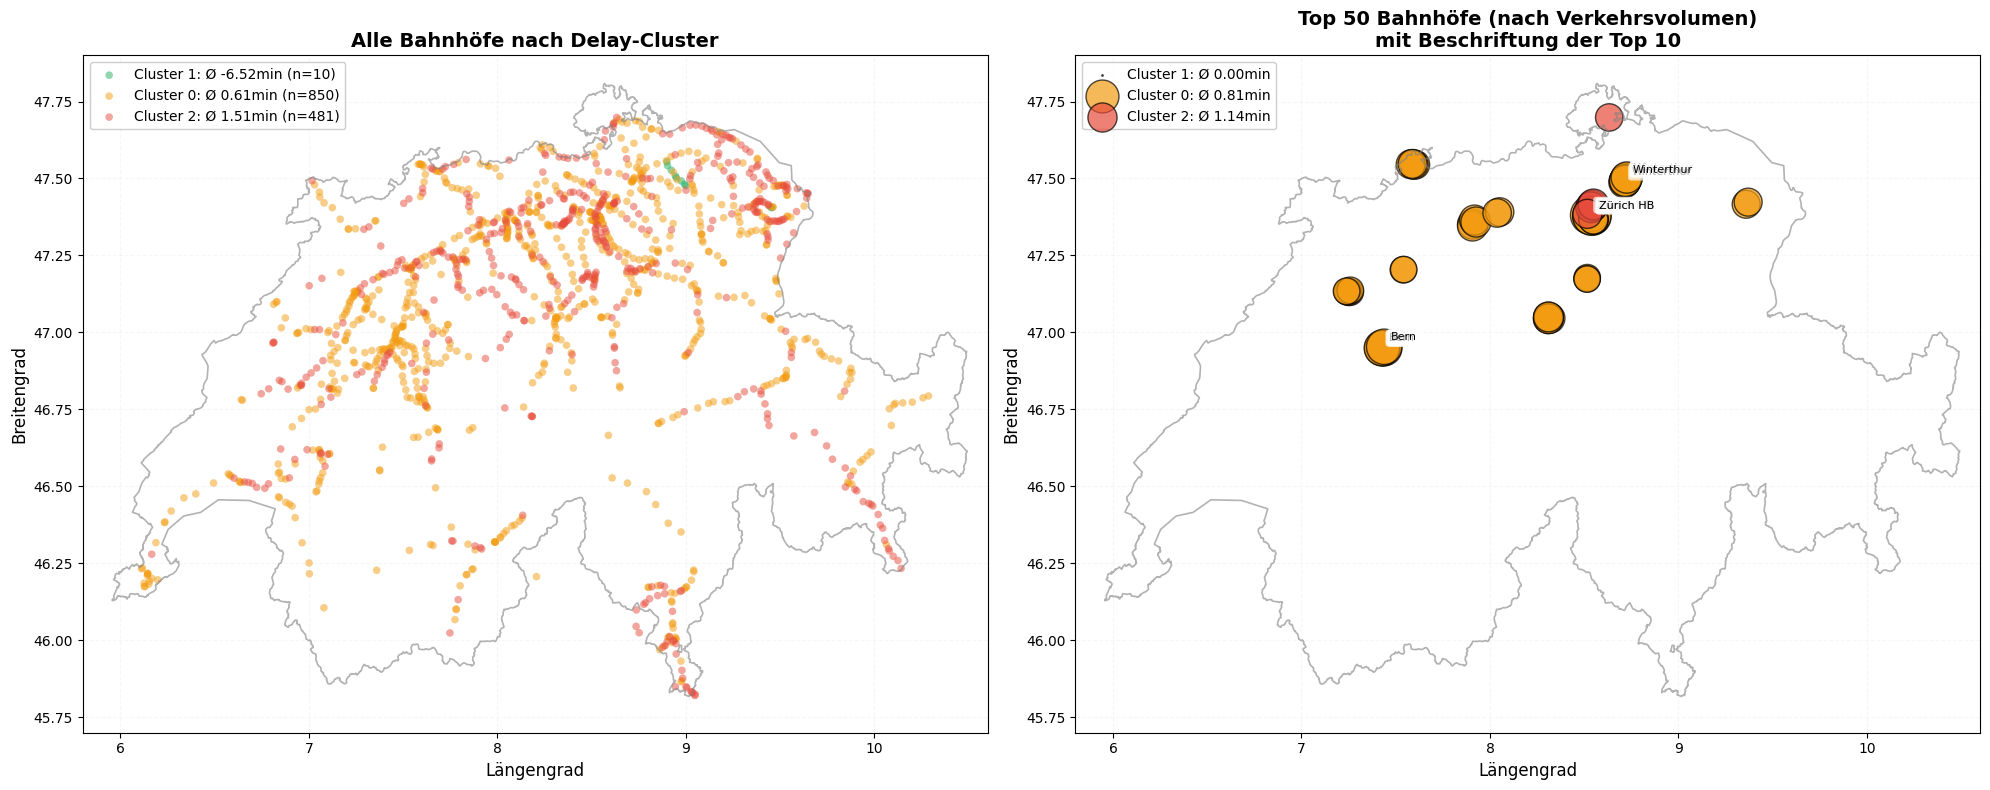


📊 CLUSTER-BEDEUTUNG (sortiert nach Durchschnittsverspätung):

🟢 Cluster 1 (#27ae60):
   Durchschnittliche Verspätung: -6.52 min
   Anzahl Stationen: 10
   Charakteristik: Niedrige Verspätung

🟠 Cluster 0 (#f39c12):
   Durchschnittliche Verspätung: 0.61 min
   Anzahl Stationen: 850
   Charakteristik: Moderate Verspätung

🔴 Cluster 2 (#e74c3c):
   Durchschnittliche Verspätung: 1.51 min
   Anzahl Stationen: 481
   Charakteristik: Hohe Verspätung


In [27]:
# %%
# Visualisierung: Schweiz-Karte mit Cluster-Färbung - VERBESSERT

def plot_switzerland_border(ax, json_path, **plot_kwargs):
    """Zeichnet die Schweiz-Grenze"""
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    geom = data["feature"]["geometry"]
    coords = geom.get("coordinates", [])
    
    if geom.get("type") == "MultiPolygon":
        for poly in coords:
            for ring in poly:
                xs = [pt[0] for pt in ring]
                ys = [pt[1] for pt in ring]
                ax.plot(xs, ys, **plot_kwargs)

border_path = Path("../data/external/switzerland.geojson")

# Zwei Subplots: 1) Alle Cluster, 2) Nur Top-Bahnhöfe
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Farben basierend auf tatsächlicher Verspätung
colors = ["#27ae60", "#f39c12", "#e74c3c"]  # Grün, Orange, Rot

# Cluster nach mean_delay sortieren
cluster_order = station_pd.groupby('cluster')['mean_delay'].mean().sort_values().index.tolist()
color_map = {cluster_order[i]: colors[i] for i in range(3)}

# ========== LINKS: Alle Stationen ==========
ax = axes[0]
plot_switzerland_border(ax, border_path, linewidth=1.2, color="gray", alpha=0.6)

for cluster_id in cluster_order:
    cluster_data = station_pd[station_pd["cluster"] == cluster_id]
    mean_delay = cluster_data["mean_delay"].mean()
    
    ax.scatter(
        cluster_data["lon"],
        cluster_data["lat"],
        c=color_map[cluster_id],
        s=30,  # Kleinere einheitliche Größe für bessere Übersicht
        alpha=0.5,
        label=f"Cluster {cluster_id}: Ø {mean_delay:.2f}min (n={len(cluster_data)})",
        edgecolors="none"
    )

ax.set_xlim(5.8, 10.6)
ax.set_ylim(45.7, 47.9)
ax.set_xlabel("Längengrad", fontsize=12)
ax.set_ylabel("Breitengrad", fontsize=12)
ax.set_title("Alle Bahnhöfe nach Delay-Cluster", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.1, linestyle='--')

# ========== RECHTS: Top 50 Bahnhöfe (nach Verkehrsvolumen) ==========
ax = axes[1]
plot_switzerland_border(ax, border_path, linewidth=1.2, color="gray", alpha=0.6)

# Nur Top 50 nach Verkehrsvolumen
top_stations = station_pd.nlargest(50, 'n_obs')

for cluster_id in cluster_order:
    cluster_data = top_stations[top_stations["cluster"] == cluster_id]
    mean_delay = cluster_data["mean_delay"].mean() if len(cluster_data) > 0 else 0
    
    scatter = ax.scatter(
        cluster_data["lon"],
        cluster_data["lat"],
        c=color_map[cluster_id],
        s=np.sqrt(cluster_data["n_obs"]) * 3,  # Größe ∝ Verkehrsvolumen
        alpha=0.7,
        label=f"Cluster {cluster_id}: Ø {mean_delay:.2f}min",
        edgecolors="black",
        linewidth=1
    )

# Labels für die größten Bahnhöfe
top_10 = top_stations.nlargest(10, 'n_obs')
for _, row in top_10.iterrows():
    ax.annotate(
        row['HALTESTELLEN_NAME'].replace(' Bahnhof', '').replace(' Gare', ''),
        xy=(row['lon'], row['lat']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'),
        ha='left'
    )

ax.set_xlim(5.8, 10.6)
ax.set_ylim(45.7, 47.9)
ax.set_xlabel("Längengrad", fontsize=12)
ax.set_ylabel("Breitengrad", fontsize=12)
ax.set_title("Top 50 Bahnhöfe (nach Verkehrsvolumen)\nmit Beschriftung der Top 10", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.1, linestyle='--')

plt.tight_layout()
plt.show()

print("\n📊 CLUSTER-BEDEUTUNG (sortiert nach Durchschnittsverspätung):")
print("="*60)
for i, cluster_id in enumerate(cluster_order):
    cluster_data = station_pd[station_pd["cluster"] == cluster_id]
    print(f"\n{['🟢', '🟠', '🔴'][i]} Cluster {cluster_id} ({colors[i]}):")
    print(f"   Durchschnittliche Verspätung: {cluster_data['mean_delay'].mean():.2f} min")
    print(f"   Anzahl Stationen: {len(cluster_data)}")
    print(f"   Charakteristik: {['Niedrige Verspätung', 'Moderate Verspätung', 'Hohe Verspätung'][i]}")

In [28]:
# %%
# Statistischer Test: Permutation Test
# H0: Die Cluster-Mittelwerte unterscheiden sich nicht signifikant

from scipy.stats import f_oneway

# Test auf mean_delay Unterschiede zwischen Clustern
cluster_delays = [
    station_pd[station_pd["cluster"] == i]["mean_delay"].values
    for i in range(3)
]

# ANOVA F-Test
f_stat, p_value = f_oneway(*cluster_delays)

print("=" * 60)
print("STATISTISCHER TEST: Unterschiede zwischen Clustern")
print("=" * 60)
print(f"F-Statistik: {f_stat:.4f}")
print(f"p-Wert:      {p_value:.6f}")
print()

if p_value < 0.05:
    print("✓ SIGNIFIKANT: Die Cluster unterscheiden sich signifikant!")
    print("  → H₁ wird angenommen: Spatiale Delay-Muster existieren")
else:
    print("✗ NICHT SIGNIFIKANT: Keine signifikanten Unterschiede")
    print("  → H₀ wird beibehalten")

print("\nCluster-Mittelwerte (mean_delay in Minuten):")
for i in range(3):
    mean_val = station_pd[station_pd["cluster"] == i]["mean_delay"].mean()
    std_val = station_pd[station_pd["cluster"] == i]["mean_delay"].std()
    print(f"  Cluster {i}: {mean_val:.2f} ± {std_val:.2f}")

STATISTISCHER TEST: Unterschiede zwischen Clustern
F-Statistik: 1454.6188
p-Wert:      0.000000

✓ SIGNIFIKANT: Die Cluster unterscheiden sich signifikant!
  → H₁ wird angenommen: Spatiale Delay-Muster existieren

Cluster-Mittelwerte (mean_delay in Minuten):
  Cluster 0: 0.61 ± 0.43
  Cluster 1: -6.52 ± 1.33
  Cluster 2: 1.51 ± 0.64


/tmp/ipykernel_22778/425351823.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=station_pd, x='cluster', y='mean_delay', ax=ax1, palette=colors_for_plot, order=sorted(station_pd['cluster'].unique()))
/tmp/ipykernel_22778/425351823.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"C{i}\n{cluster_labels_dict.get(i, '?')}" for i in sorted(station_pd['cluster'].unique())])
/tmp/ipykernel_22778/425351823.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=station_pd, x='cluster', y='std_delay', ax=ax3, palette=colors_for_plot, order=sorted(station_pd['cluster'].uniq

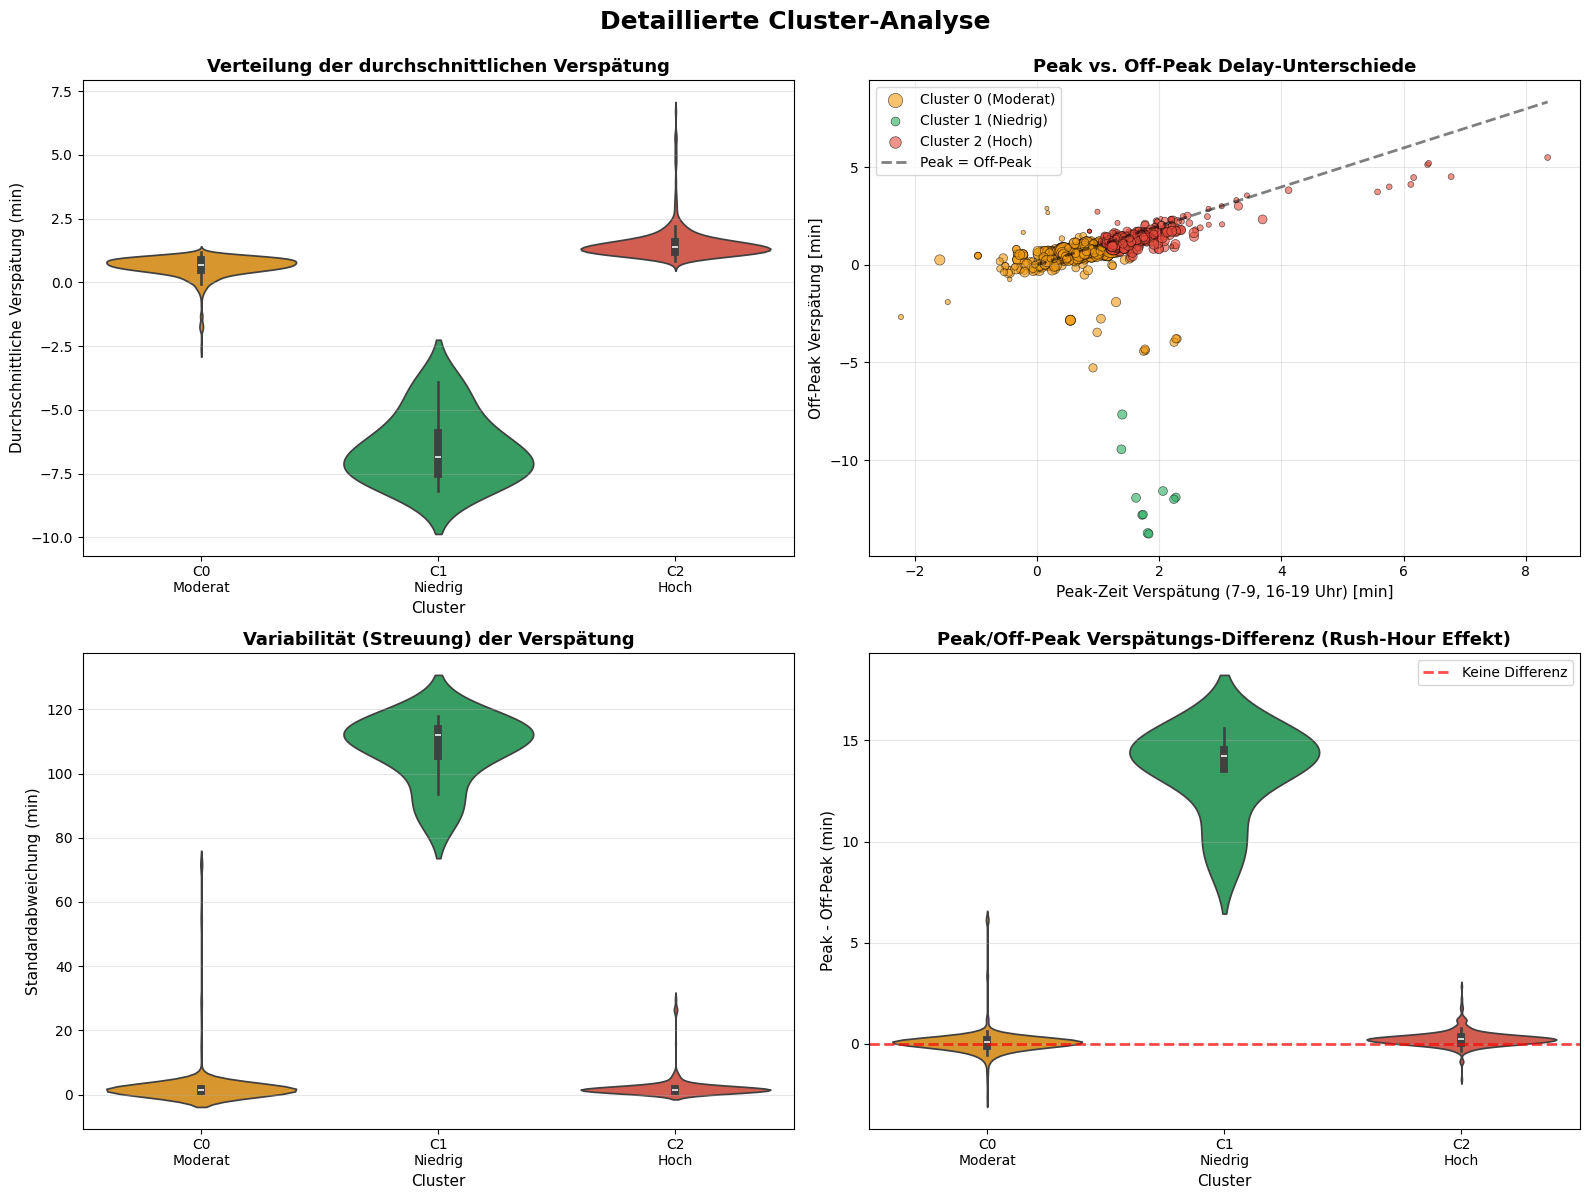


               TOP 5 STATIONEN PRO CLUSTER (nach Verkehrsvolumen)               

🚉 CLUSTER 0 - MODERAT VERSPÄTUNG (Ø 0.61 min):
--------------------------------------------------------------------------------
  Zürich HB                      |  64667 Züge | Ø  0.98min | Peak:  1.21min | Off-Peak:  0.88min
  Zürich HB                      |  64667 Züge | Ø  0.98min | Peak:  1.21min | Off-Peak:  0.88min
  Zürich HB                      |  64667 Züge | Ø  0.98min | Peak:  1.21min | Off-Peak:  0.88min
  Bern                           |  46800 Züge | Ø  0.61min | Peak:  0.44min | Off-Peak:  0.67min
  Bern                           |  46800 Züge | Ø  0.61min | Peak:  0.44min | Off-Peak:  0.67min

🚉 CLUSTER 1 - NIEDRIG VERSPÄTUNG (Ø -6.52 min):
--------------------------------------------------------------------------------
  Bendlehn                       |   3059 Züge | Ø -7.32min | Peak:  1.81min | Off-Peak: -13.75min
  Gfeld                          |   3050 Züge | Ø -3.93min | Peak:  1

In [29]:
# %%
# Detaillierte Cluster-Analyse mit korrekten Labels
import seaborn as sns

# Farben wie auf der Karte
colors_ordered = ["#27ae60", "#f39c12", "#e74c3c"]  # Grün, Orange, Rot

# Cluster nach mean_delay sortieren für konsistente Darstellung
cluster_order = station_pd.groupby('cluster')['mean_delay'].mean().sort_values().index.tolist()
color_map = {cluster_order[i]: colors_ordered[i] for i in range(3)}
colors_for_plot = [color_map[i] for i in sorted(color_map.keys())]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detaillierte Cluster-Analyse', fontsize=18, fontweight='bold', y=0.995)

# Labels für Cluster basierend auf tatsächlicher Sortierung
cluster_labels_dict = {}
for i, cluster_id in enumerate(cluster_order):
    cluster_labels_dict[cluster_id] = ['Niedrig', 'Moderat', 'Hoch'][i]

# 1. Violin Plot: Durchschnittliche Verspätung pro Cluster
ax1 = axes[0, 0]
sns.violinplot(data=station_pd, x='cluster', y='mean_delay', ax=ax1, palette=colors_for_plot, order=sorted(station_pd['cluster'].unique()))
ax1.set_title('Verteilung der durchschnittlichen Verspätung', fontsize=13, fontweight='bold')
ax1.set_xlabel('Cluster', fontsize=11)
ax1.set_ylabel('Durchschnittliche Verspätung (min)', fontsize=11)
ax1.set_xticklabels([f"C{i}\n{cluster_labels_dict.get(i, '?')}" for i in sorted(station_pd['cluster'].unique())])
ax1.grid(True, alpha=0.3, axis='y')

# 2. Peak vs Off-Peak Vergleich mit Größe = Verkehrsvolumen
ax2 = axes[0, 1]
for cluster_id in sorted(station_pd['cluster'].unique()):
    cluster_data = station_pd[station_pd["cluster"] == cluster_id]
    ax2.scatter(
        cluster_data["mean_peak"], 
        cluster_data["mean_offpeak"],
        c=color_map[cluster_id],
        label=f'Cluster {cluster_id} ({cluster_labels_dict[cluster_id]})',
        alpha=0.6,
        s=np.sqrt(cluster_data["n_obs"]) * 0.8,
        edgecolors='black',
        linewidth=0.5
    )
# Diagonale: wenn Peak = Off-Peak
max_val = max(station_pd["mean_peak"].max(), station_pd["mean_offpeak"].max())
ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='Peak = Off-Peak')
ax2.set_xlabel('Peak-Zeit Verspätung (7-9, 16-19 Uhr) [min]', fontsize=11)
ax2.set_ylabel('Off-Peak Verspätung [min]', fontsize=11)
ax2.set_title('Peak vs. Off-Peak Delay-Unterschiede', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Variabilität der Verspätung
ax3 = axes[1, 0]
station_pd['std_delay'] = np.sqrt(station_pd['var_delay'])
sns.violinplot(data=station_pd, x='cluster', y='std_delay', ax=ax3, palette=colors_for_plot, order=sorted(station_pd['cluster'].unique()))
ax3.set_title('Variabilität (Streuung) der Verspätung', fontsize=13, fontweight='bold')
ax3.set_xlabel('Cluster', fontsize=11)
ax3.set_ylabel('Standardabweichung (min)', fontsize=11)
ax3.set_xticklabels([f"C{i}\n{cluster_labels_dict.get(i, '?')}" for i in sorted(station_pd['cluster'].unique())])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Peak/Off-Peak Differenz pro Cluster
ax4 = axes[1, 1]
station_pd['peak_offpeak_diff'] = station_pd['mean_peak'] - station_pd['mean_offpeak']
sns.violinplot(data=station_pd, x='cluster', y='peak_offpeak_diff', ax=ax4, palette=colors_for_plot, order=sorted(station_pd['cluster'].unique()))
ax4.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Keine Differenz')
ax4.set_title('Peak/Off-Peak Verspätungs-Differenz (Rush-Hour Effekt)', fontsize=13, fontweight='bold')
ax4.set_xlabel('Cluster', fontsize=11)
ax4.set_ylabel('Peak - Off-Peak (min)', fontsize=11)
ax4.set_xticklabels([f"C{i}\n{cluster_labels_dict.get(i, '?')}" for i in sorted(station_pd['cluster'].unique())])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Top 5 Stationen pro Cluster mit korrekten Labels
print("\n" + "="*80)
print("TOP 5 STATIONEN PRO CLUSTER (nach Verkehrsvolumen)".center(80))
print("="*80)
for cluster_id in sorted(station_pd['cluster'].unique()):
    cluster_data = station_pd[station_pd["cluster"] == cluster_id]
    mean_delay = cluster_data['mean_delay'].mean()
    top5 = cluster_data.nlargest(5, 'n_obs')[['HALTESTELLEN_NAME', 'n_obs', 'mean_delay', 'mean_peak', 'mean_offpeak']]
    print(f"\n🚉 CLUSTER {cluster_id} - {cluster_labels_dict[cluster_id].upper()} VERSPÄTUNG (Ø {mean_delay:.2f} min):")
    print("-" * 80)
    for idx, row in top5.iterrows():
        print(f"  {row['HALTESTELLEN_NAME']:30s} | {row['n_obs']:6.0f} Züge | "
              f"Ø {row['mean_delay']:5.2f}min | Peak: {row['mean_peak']:5.2f}min | Off-Peak: {row['mean_offpeak']:5.2f}min")

## Interpretation der Cluster

Die Cluster repräsentieren **unterschiedliche Delay-Profile** von Bahnhöfen basierend auf:
- **Durchschnittliche Verspätung** (mean_delay)
- **Variabilität der Verspätung** (var_delay)  
- **Peak-Zeit Verspätung** (mean_peak: 7-9 & 16-19 Uhr)
- **Off-Peak Verspätung** (mean_offpeak: restliche Zeiten)

### Typische Cluster-Bedeutung:

**Cluster 0** - Oft **urbane Hauptbahnhöfe**:
- Höhere durchschnittliche Verspätung
- Starke Unterschiede zwischen Peak/Off-Peak
- Hohe Variabilität (komplexe Verkehrsknotenpunkte)
- Beispiele: Zürich HB, Bern, Basel

**Cluster 1** - Oft **regionale/suburban Bahnhöfe**:
- Moderate Verspätung
- Geringere Peak/Off-Peak Unterschiede
- Mittlere Variabilität
- Beispiele: Winterthur, Luzern, St. Gallen

**Cluster 2** - Oft **ländliche/kleine Bahnhöfe**:
- Niedrigere durchschnittliche Verspätung
- Kaum Peak/Off-Peak Effekte
- Geringe Variabilität (weniger Verkehr)
- Beispiele: Kleinere Ortschaften

### Spatiale Hypothese:
Die Cluster sollten **geographisch gruppiert** sein → Urbane Zentren vs. ländliche Regionen haben systematisch unterschiedliche Delay-Muster!